Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Class distribution:
 Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

Number of 'normal' (healthy) samples for training: 500

Number of support vectors: 68 / 500

OneClassSVM anomaly detection results:
                          precision    recall  f1-score   support

Anomaly (-1)  [Diabetes]      0.689     0.313     0.431       268
  Normal (+1)  [Healthy]      0.715     0.924     0.806       500

                accuracy                          0.711       768
               macro avg      0.702     0.619     0.619       768
            weighted avg      0.706     0.711     0.675       768


Confusion matrix (rows = true, columns = predicted):
[[ 84 184]
 [ 38 462]]

Detected as normal (correct for healthy):   462 / 500
Detected as anomaly (correct for diabetes):   84 / 268


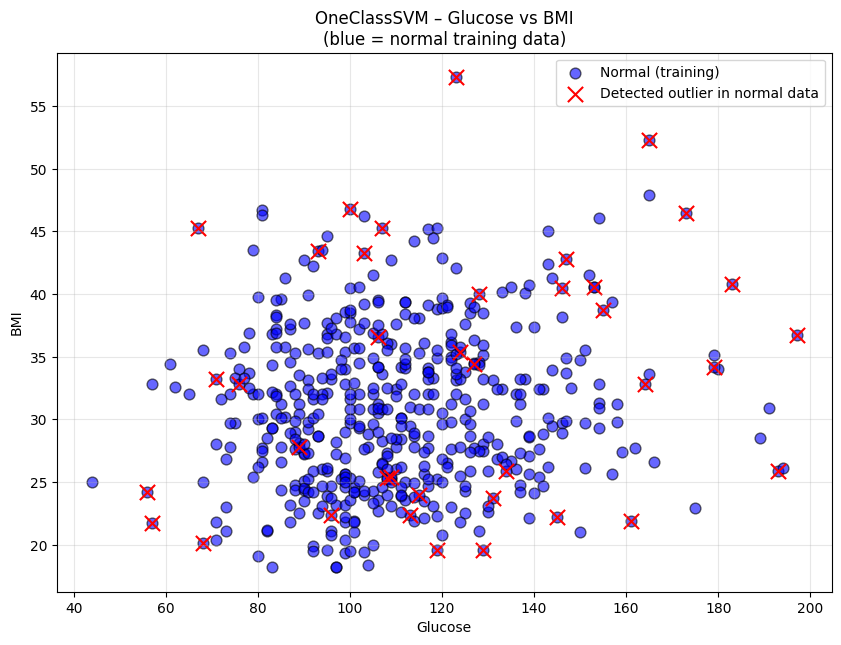

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix

# ────────────────────────────────────────────────
# 1. Load the same diabetes dataset
# ────────────────────────────────────────────────
url = "https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv"
data = pd.read_csv(url)

print("Shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nClass distribution:\n", data['Outcome'].value_counts(normalize=True))

# ────────────────────────────────────────────────
# 2. Handle invalid zeros (important for realistic modeling)
# ────────────────────────────────────────────────
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in cols_with_zeros:
    data[col] = data[col].replace(0, data[col].median())

# ────────────────────────────────────────────────
# 3. We pretend we only have "normal" (healthy) people for training
#    → class 0 = healthy / normal
# ────────────────────────────────────────────────
normal_data = data[data['Outcome'] == 0].copy()
print(f"\nNumber of 'normal' (healthy) samples for training: {len(normal_data)}")

# Features only – no labels needed for OneClassSVM
X_normal = normal_data.drop('Outcome', axis=1)

# For evaluation later we keep some real anomalies (diabetes = class 1)
X_anomalies = data[data['Outcome'] == 1].drop('Outcome', axis=1)

# ────────────────────────────────────────────────
# 4. Scaling – very important for OneClassSVM + RBF kernel
# ────────────────────────────────────────────────
scaler = StandardScaler()

X_normal_scaled = scaler.fit_transform(X_normal)
X_anomalies_scaled = scaler.transform(X_anomalies)

# ────────────────────────────────────────────────
# 5. Train OneClassSVM only on normal data
# ────────────────────────────────────────────────
model = OneClassSVM(
    kernel='rbf',
    nu=0.08,           # expected fraction of outliers in training data
    gamma='scale',
    # gamma=0.001      # you can also try fixed values
)

model.fit(X_normal_scaled)

print(f"\nNumber of support vectors: {len(model.support_)} / {len(X_normal)}")

# ────────────────────────────────────────────────
# 6. Predict on both normal and real anomalies
# ────────────────────────────────────────────────
# +1 = inlier  (considered normal)
# -1 = outlier (considered anomaly)

y_pred_normal = model.predict(X_normal_scaled)
y_pred_anomalies = model.predict(X_anomalies_scaled)

# For evaluation: we treat real diabetes patients as "true anomalies"
true_labels_normal   = np.ones(len(y_pred_normal))   * (+1)   # normal = inlier
true_labels_anomalies = np.ones(len(y_pred_anomalies)) * (-1)  # diabetes = outlier

# Combine for overall metrics
y_true  = np.concatenate([true_labels_normal, true_labels_anomalies])
y_pred  = np.concatenate([y_pred_normal, y_pred_anomalies])

# ────────────────────────────────────────────────
# 7. Results
# ────────────────────────────────────────────────
print("\nOneClassSVM anomaly detection results:")
print(classification_report(
    y_true,
    y_pred,
    target_names=['Anomaly (-1)  [Diabetes]', 'Normal (+1)  [Healthy]'],
    digits=3
))

print("\nConfusion matrix (rows = true, columns = predicted):")
print(confusion_matrix(y_true, y_pred))

# Quick interpretation helper
normal_detected_as_normal = (y_pred_normal == 1).sum()
anomalies_detected_as_anomaly = (y_pred_anomalies == -1).sum()

print(f"\nDetected as normal (correct for healthy):   {normal_detected_as_normal:3d} / {len(y_pred_normal)}")
print(f"Detected as anomaly (correct for diabetes):  {anomalies_detected_as_anomaly:3d} / {len(y_pred_anomalies)}")

# ────────────────────────────────────────────────
# 8. Optional: simple 2D visualization (Glucose vs BMI)
# ────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 7))

# Plot normal training points
ax.scatter(
    X_normal['Glucose'], X_normal['BMI'],
    c='blue', label='Normal (training)', alpha=0.6, s=60, edgecolor='k'
)

# Plot points classified as anomalies in training set
anomaly_idx = y_pred_normal == -1
if anomaly_idx.sum() > 0:
    ax.scatter(
        X_normal.loc[anomaly_idx, 'Glucose'],
        X_normal.loc[anomaly_idx, 'BMI'],
        c='red', marker='x', s=120, label='Detected outlier in normal data'
    )

ax.set_title("OneClassSVM – Glucose vs BMI\n(blue = normal training data)")
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()